# Projection-Cartographique-CASSIOPE-FAI
***

**Tutoriel :** Ce tutoriel explique comment visualiser les données de la caméra FAI avec diverses projections cartographiques  
**Mission et Instrument :** FAI (Fast Auroral Imager) sur CASSIOPE      
**Objectif astronomique :** Émissions aurorales    
**Outil principal :** Script Python3       
**Niveau du tutoriel :** Intermédiaire

Des images de la Terre peuvent être difficiles à visualiser, surtout les pôles. Il existe une variété de projections cartographiques pour visualiser des images réalistes du globe. L'objectif de ce tutoriel est de tester plusieurs projections cartographiques du module *Basemap* de *Matplotlib* avec une image du FAI. Ce tutoriel inclut deux visualisations :

1. Une image agrandie de la photo prise par le FAI ;
2. Une carte générale avec l'image du FAI agrandie dans une fenêtre.

Voici une liste de [projections cartographiques](https://matplotlib.org/basemap/api/basemap_api.html) supportées par *Basemap*.

## Bibliothèque

Le script qui suit utilise

* *numpy* : opération mathématique et array multidimentionnel
* *h5py* : ouverture de fichier .h5
* *pandas* : structure de dataframe
* *matplotlib* : tracer des figures
* *basemap* : tracer des cartes

In [69]:
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import pandas as pd
import h5py

## Carte agrandie

On commence avec une simple fonction pour identifier les latitudes et longitudes de la carte selon la projection. On va utiliser cette même fonction pour la seconde visualisation.

In [70]:
# Function identifiant les parallèles et les méridiens d'une carte
# Les étiquettes dépendent de la projection
# Paramètres :
# m : la carte (classe Basemap)
# proj : l'id de la projection Basemap (string)
# interPara : l'intervale entre les étiquettes des parallèles (float)
# interMeri : l'interval entre les étiquettes des méridiens (float)
# Retourne la carte
def drawParaMeri(m,proj,interPara,interMeri):
    
    # Si la projection est Orthographic, Near-Sided Perspective, Geostationary ou Azimuthal Equidistant
    if(proj in ['ortho','nsper','geos','aeqd']):
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2)
    # Si la projection est Cylindrical Equal Area, Miller Cylindrical ou Gall Stereographic Cylindrical
    elif(proj in ['cyl','mill','gall']):
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2, labels=[1,0,0,1], fontsize=8)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2, labels=[1,0,0,1], fontsize=8)
    # Si la projection est Stereographic, Equidistant Conic, Lambert Conformal, 
    # Lambert Azimuthal Equal Area ou Albers Equal Area
    elif(proj in ['stere','eqdc','lcc','laea','aea']):
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2, labels=[0,1,0,1], fontsize=8)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2, labels=[1,0,1,0], fontsize=8)
    # Pour les autres projections
    else:
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2, labels=[1,1,0,0], fontsize=8)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2, labels=[0,0,1,1], fontsize=8)

    return(m)

Ensuite, on a une fonction pour créer la carte. Sur la carte, l'image du FAI sera dessinée avec des marges.

In [71]:
# Fonction traçant une carte agrandie
# Paramètres
# ax : l'axe utilisé pour créer la carte (Axe)
# lon : les longitudes de l'image (array of float)
# lat : les latitudes de l'image (array of float)
# proj : l'id de la projection cartographique (string)
# interPara : l'intervalle entre les graduations des parallèles (float)
# interMeri : l'intervalle entre les graduations des méridiens (float)
# lonmargins : les marges sur l'axe des x (longitude) (float)
# latmargins : les marges sur l'axe des y (latitude) (float)
# Returns the map
def createZoomedMap(ax,lon,lat,proj,interPara,interMeri,lonmargins,latmargins):
    
    # On veut une petite carte
    width=400000
    height=200000
    minlon = np.nanmin(lon)-lonmargins
    maxlon = np.nanmax(lon)+lonmargins
    minlat = np.nanmin(lat)-latmargins
    maxlat = np.nanmax(lat)+latmargins
    
    # Si la projection est Lambert Azimuthal Equal Area, Albers Equal Area, 
    # Stereographic, Equidistant Conic ou Lambert Conformal
    if(proj in ['laea','aea','stere','eqdc','lcc']):
        m = Basemap(projection=proj, width=width, height=height,
                lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)  
    # Si la projection est Orthographic ou Near-Sided Perspective
    elif(proj in ['ortho','nsper']):
        m = Basemap(projection=proj, lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
    # Pour les autres projections
    else:
        m = Basemap(projection=proj,lon_0=lon[139][127], lat_0=lat[139][127],ax=ax,
                    llcrnrlon=minlon, llcrnrlat=minlat, urcrnrlon=maxlon, urcrnrlat=maxlat)
    
    # Dessiner les frontières
    m.drawcoastlines(linewidth=0.75)
    m.drawcountries(linewidth=0.75)
    
    # La couleur de la carte
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgreen',lake_color='lightblue',zorder=1)
    
    # Ajouter les graduations
    m = drawParaMeri(m, proj, interPara, interMeri)
    
    return(m)

Maintenant, voyons comment la carte avec l'image est tracée.

In [72]:
# Fonction traçant l'image du FAI sur une carte agrandie 
# Paramètres :
# file : le répertoire du fichier (string)
# proj : l'id de la projection Basemap (string)
# title : le titre de la figure (string)
# pct : le % top des valeurs qui sera en blanc (default=0.01) (float)
# interPara : l'intervalle entre les étiquettes des parallèles (default=2.) (float)
# interMeri : l'intervalle entre les étiquettes des méridiens (default=5.)
# lonmargins : les marges sur l'axe des x (longitude) (float)
# latmargins : les marges sur l'axe des y (latitude) (float)
# Returne rien
def plotZoomedMap(file, proj, title, pct=0.01, interPara=1., interMeri=2., lonmargins=2., latmargins=1.):
    
    # Liste des projections supportées par ce code
    supportedProjection = ['ortho','nsper','cyl','mill', 'gall', 'stere', 'aea',
                           'eqdc','aeqd','lcc','laea']
    # Si c'est une projection différente, arrêt
    if(proj not in supportedProjection):
        print("\nCette projection n'est pas supportée ou pas recommandée")
        return()
    
    # Ouvrir le fichier et extraire les latitudes, les longitudes, l'image et le facteur de conversion
    with h5py.File(file, 'r') as f:
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        image = np.array(f.get('FAI Image'))/conversion
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
    
    # Retirer la dernière ligne et colonne, puisque qu'elles indiquent
    # seulement le coin en bas à droite de l'image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1) 
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Créer la figure et ajouter le titre
    fig = plt.figure(figsize=(7,4),dpi=150)
    fig.suptitle(title)
    
    # Créer l'axe et définir les marges
    ax = plt.subplot(111)
    plt.subplots_adjust(left=0.1,right=0.9,top=0.88,bottom=0.05,wspace=0.15,hspace=0.05)
    
    # Créer la carte
    m = createZoomedMap(ax,lon,lat,proj,interPara,interMeri,lonmargins,latmargins)
    
    # Définir la norme de la colorbar
    n = int(image.size*pct)
    ind = np.argpartition(image.flatten(), -n)[-n:]
    inf = min(image.flatten()[ind])
    norm = colors.Normalize(vmin=np.nanmin(image),vmax=inf)
    
    # Si la projection est Orthographic ou Near-Side Perspective, agrandir l'image
    if proj in ['ortho','nsper']:
        lx,ly=m(np.nanmin(lon)-lonmargins,np.nanmin(lat)-latmargins)
        ux,uy=m(np.nanmax(lon)+lonmargins,np.nanmax(lat)+latmargins)
        ax.set_xlim(lx,ux)
        ax.set_ylim(ly,uy)
    
    # Tracer l'image et ajouter la colorbar
    sc = m.scatter(lon,lat,c=image,cmap='binary_r',norm=norm, latlon=True,zorder=10)
    c = fig.colorbar(sc,orientation='horizontal', ax=ax, pad=0.05, shrink=0.75, )
    c.ax.tick_params(labelsize=8)
    c.set_label("Luminosité (Data Unit)", fontsize=9) 
    
    return()    

Testons le tout!

In [73]:
file='FAI_lv1_NIR_20210111_062703_062703_6.0.0.h5'

**Cartes rectangulaires**

()

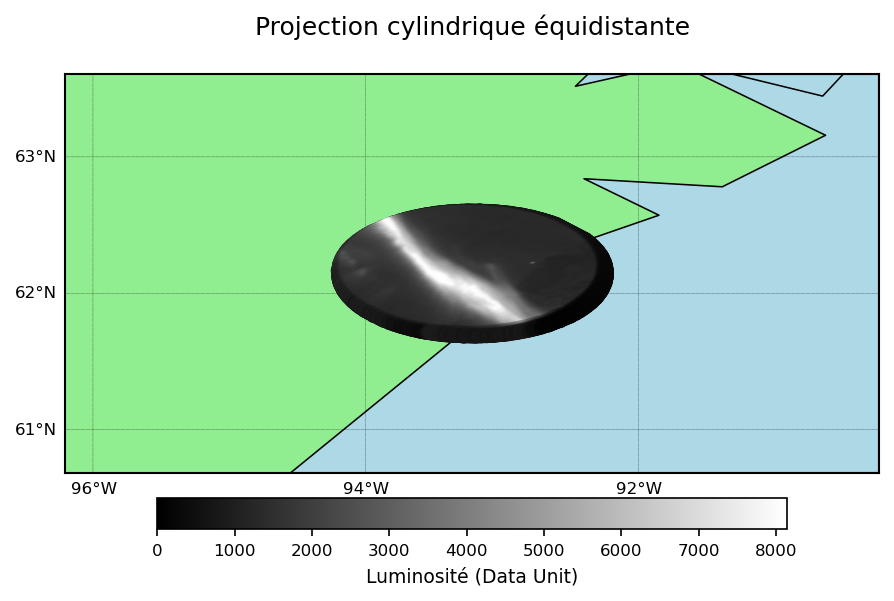

In [74]:
plotZoomedMap(file,'cyl', 'Projection cylindrique équidistante')

()

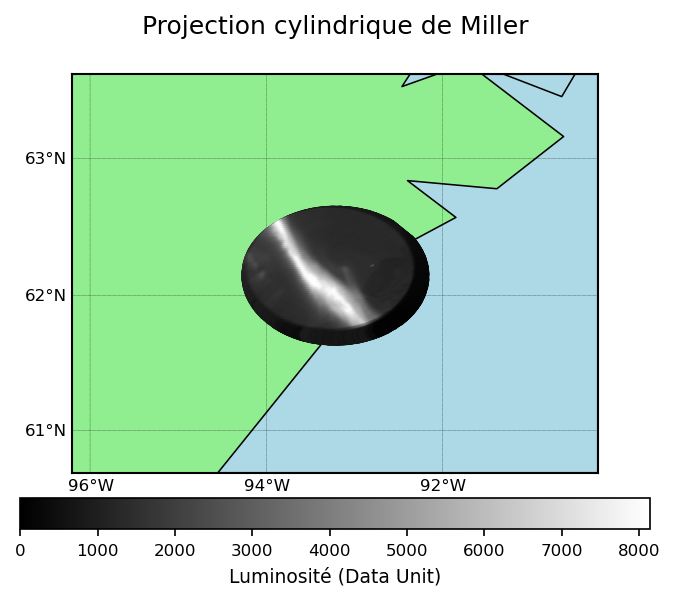

In [75]:
plotZoomedMap(file,'mill', 'Projection cylindrique de Miller')

()

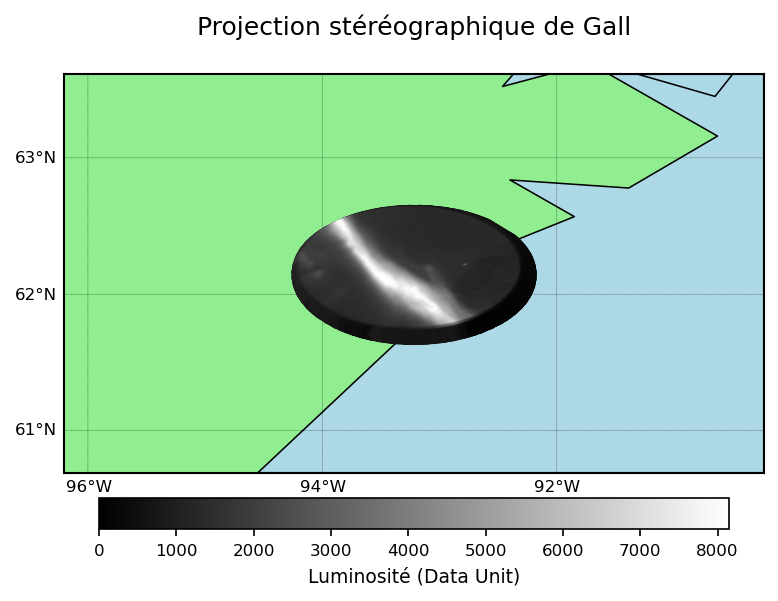

In [76]:
plotZoomedMap(file, 'gall', 'Projection stéréographique de Gall')

**Cartes du globe**

()

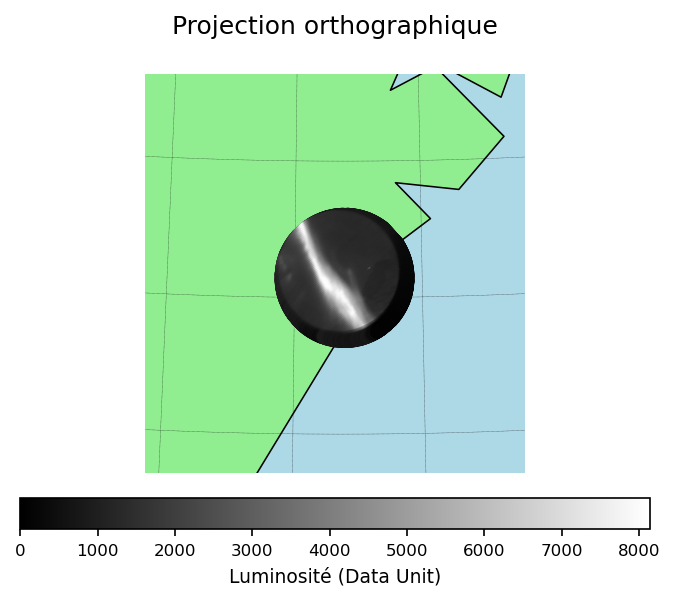

In [77]:
plotZoomedMap(file, 'ortho', 'Projection orthographique')

()

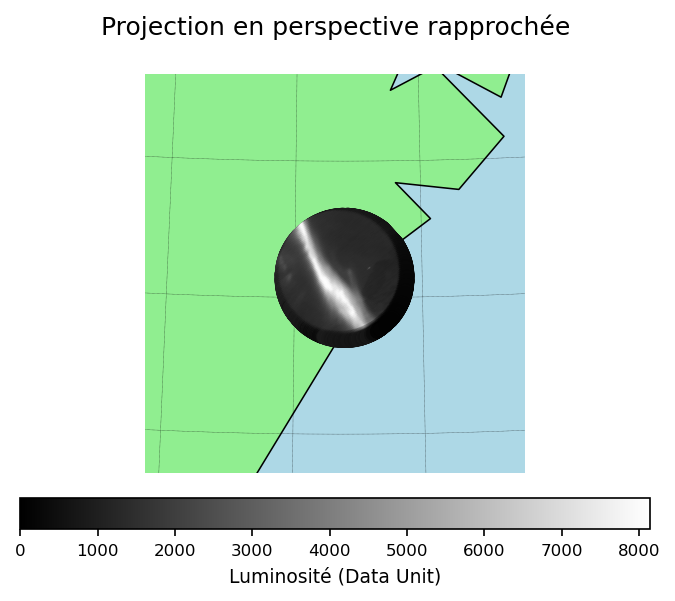

In [78]:
plotZoomedMap(file, 'nsper', 'Projection en perspective rapprochée')

()

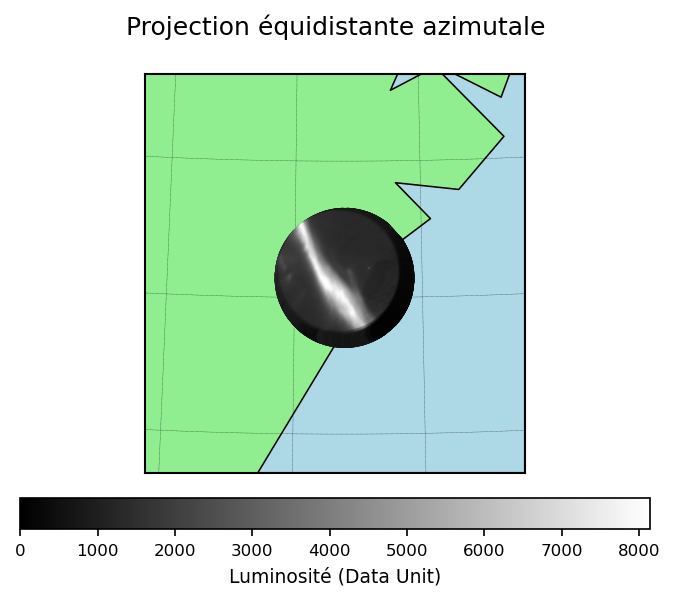

In [79]:
plotZoomedMap(file, 'aeqd', 'Projection équidistante azimutale')

**Cartes rectangulaires avec transformation**

()

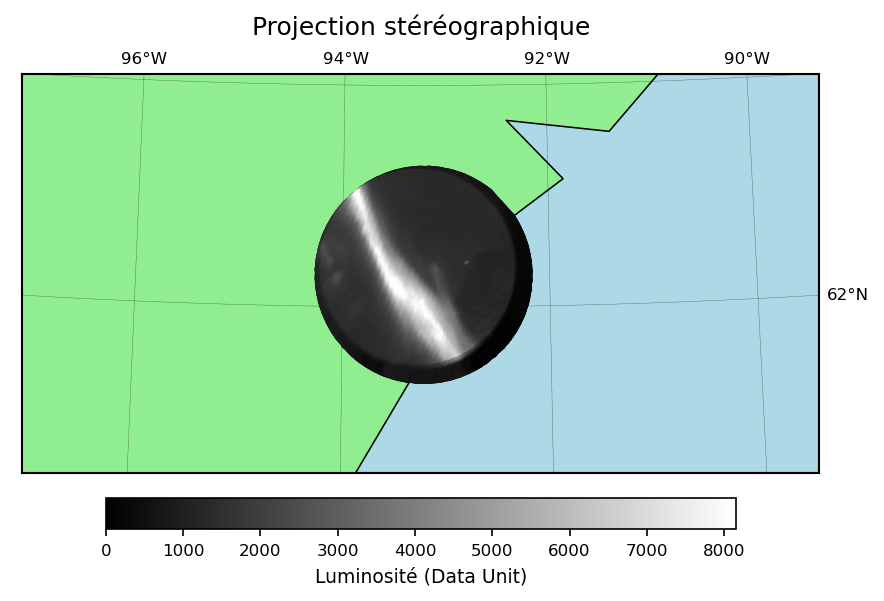

In [80]:
plotZoomedMap(file, 'stere', 'Projection stéréographique')

()

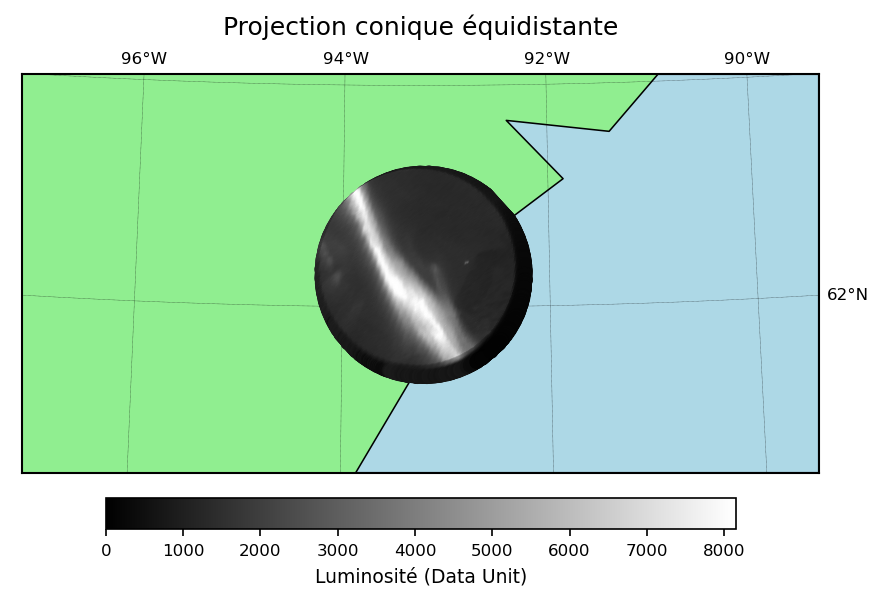

In [81]:
plotZoomedMap(file, 'eqdc', 'Projection conique équidistante')

()

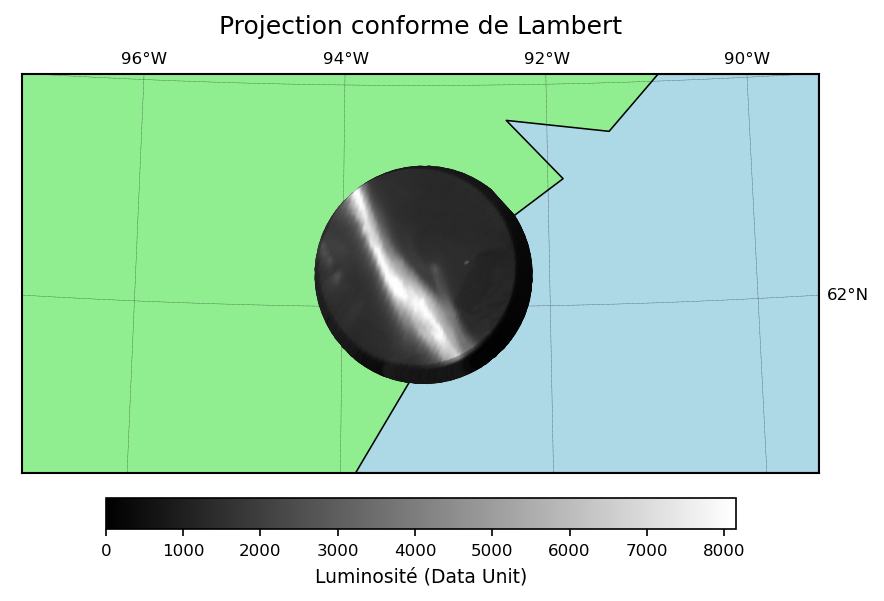

In [82]:
plotZoomedMap(file, 'lcc', 'Projection conforme de Lambert')

()

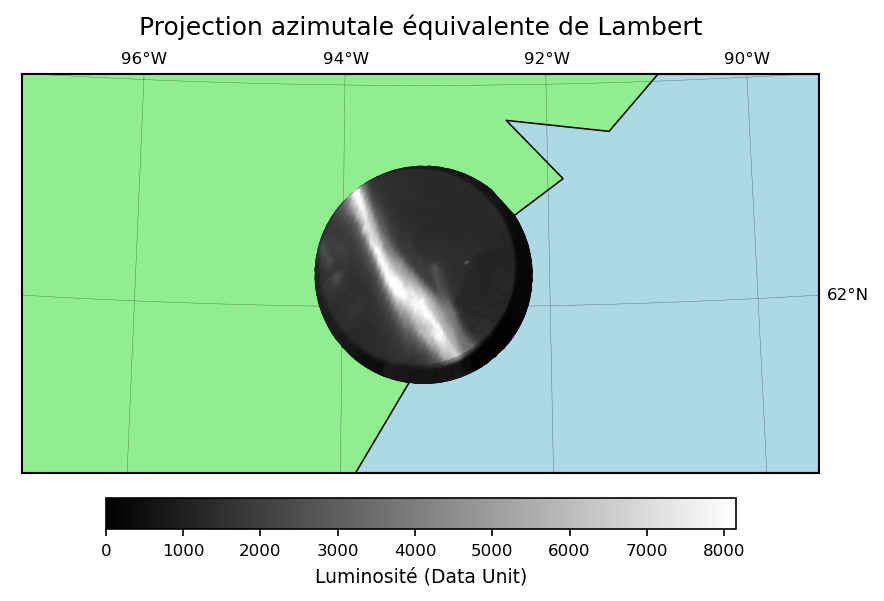

In [83]:
plotZoomedMap(file, 'laea', 'Projection azimutale équivalente de Lambert')

()

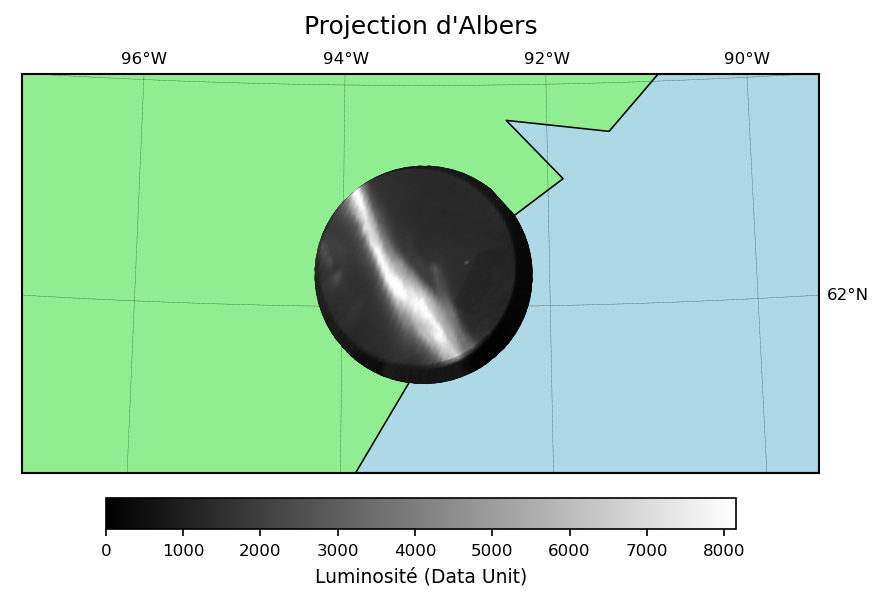

In [84]:
plotZoomedMap(file, 'aea', "Projection d'Albers")

In [85]:
plt.close('all')

## Carte générale

La fonction pour identifier les parallèles et méridiens est la même que plus haut. Débutons par tracer la carte du globe.

In [86]:
# Fonction pour tracer une carte générale
# Paramètres :
# ax : l'axe utilisé pour créer la carte (Axe)
# lon : les longitudes de l'image (array of float)
# lat : les latitudes de l'image (array of float)
# proj : l'id de la projection Basemap (string)
def createMap(ax,lon,lat,proj):
    
    # Si la projection est Lambert Azimuthal Equal Area, Albers Equal Area, 
    # Stereographic, Equidistant Conic ou Lambert Conformal
    if(proj in ['laea','aea','stere','eqdc','lcc']):
        m = Basemap(projection=proj, width=12000000, height=7500000,
                    lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
    # Si la projection est propre au pôle nord
    elif(proj in ['npstere', 'npaeqd', 'nplaea']):
        m = Basemap(projection=proj, boundinglat=10,
                    lon_0=lon[139][127], ax=ax)  
    # Si la projection est propre au pôle sud
    elif(proj in ['spstere','spaeqd', 'splaea']):
        if(lon[139][127]>=0):
            m = Basemap(projection=proj, boundinglat=-10,lon_0=lon[139][127]-180, ax=ax) 
        else:
            m = Basemap(projection=proj, boundinglat=-10,lon_0=lon[139][127]+180, ax=ax)
    # Pour les autres projections
    else:
        m = Basemap(projection=proj,lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
       
    # Dessine les lignes côtières et les pays
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    
    return(m) 

La fonction suivante trace une carte du globe avec une fenêtre d'agrandissement pour l'image du FAI.

In [87]:
# Fonction pour tracer une carte agrandie sur une carte générale
# Paramètres :
# file : le répertoire du fichier (string)
# proj : l'id de la projection Basemap (string)
# title : le titre de la figure (string)
# zoom : aggrandissement à appliquer (int)
# pct : le % top des valeurs qui sera en blanc (default=0.01) (float)
# interPara : l'intervalle entre les étiquettes des parallèles (default=30.) (float)
# interMeri : l'intervalle entre les étiquettes des méridiens (default=60.) (float)
# Returne rien
def plotGeneralMap(file,proj,title,zoom,pct=0.01,interPara=30.,interMeri=60.):
    
    # Liste des projections supportées par ce script
    supportedProjection = ['ortho','nsper','cyl','mill', 'gall', 'stere', 'aea',
                           'eqdc','aeqd','npstere','spstere','npaeqd', 'spaeqd',
                           'lcc','laea','nplaea','splaea']
    # Si c'est une projection différente, arrêt
    if(proj not in supportedProjection):
        print("\nCette projection n'est pas supportée ou pas recommandée")
        return()
    
    # Ouvrir le fichier et extraire les latitudes, longitudes, l'image et le facteur de conversion
    with h5py.File(file, 'r') as f:
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        image = np.array(f.get('FAI Image'))/conversion
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
    
    # Retirer la dernière ligne et colonne, puisque qu'elles indiquent
    # seulement le coin en bas à droite de l'image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1)  
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Créer la figure et ajouter le titre
    fig = plt.figure(figsize=(7,4),dpi=150)
    fig.suptitle(title)
    # Créer l'axe et définir les marges
    ax = plt.subplot(111)
    plt.subplots_adjust(left=0.1,right=0.9,top=0.88,bottom=0.05,wspace=0.15,hspace=0.05)
    # Créer et identifier la carte générale
    m = createMap(ax,lon,lat,proj)
    m = drawParaMeri(m, proj, interPara,interMeri)
    contour = m.drawmapboundary(linewidth=1,color='k')
    contour.set_clip_on(False)
    
    # Créer la norme pour la colorbar
    n = int(image.size*pct)
    ind = np.argpartition(image.flatten(), -n)[-n:]
    inf = min(image.flatten()[ind])
    norm = colors.Normalize(vmin=np.nanmin(image),vmax=inf)
    
    # Tracer l'image et ajouter la colorbar
    sc = m.scatter(lon,lat,c=image,cmap='binary_r',norm=norm, latlon=True)
    c = fig.colorbar(sc,orientation='horizontal', ax=ax, pad=0.05, shrink=0.75, )
    c.ax.tick_params(labelsize=8)
    c.set_label("Luminosité (Data Unit)", fontsize=9) 
    
    # Créer l'axe de la carte agrandie
    axins = zoomed_inset_axes(ax, zoom, loc='center',bbox_to_anchor=(800,375))
    # Créer la carte agrandie
    m2 = createMap(axins,lon,lat,proj)
    # Agrandir sur le domaine de l'image
    lx,ly=m2(np.nanmin(lon)-0.5,np.nanmin(lat)-0.25)
    ux,uy=m2(np.nanmax(lon)+0.5,np.nanmax(lat)+0.25)
    axins.set_xlim(lx,ux)
    axins.set_ylim(ly,uy) 
    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
    # Tracer l'image
    m2.scatter(lon,lat,c=image,cmap='binary_r',norm=norm,latlon=True)
    
    return()

C'est le moment de l'essayer.

In [88]:
file='FAI_lv1_NIR_20190501_150819_150819_6.0.0.h5'

**Cartes rectangulaires**

()

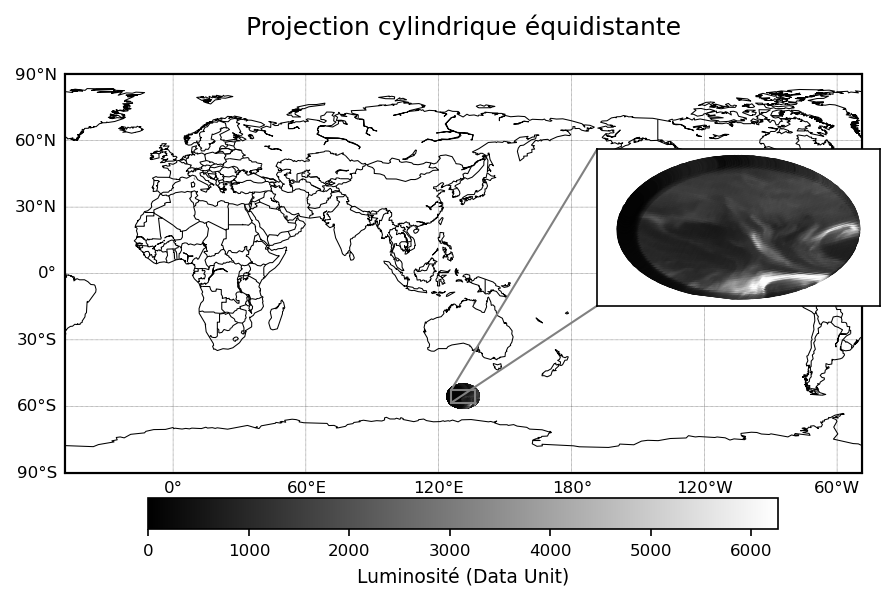

In [89]:
plotGeneralMap(file,'cyl', 'Projection cylindrique équidistante', 12)

()

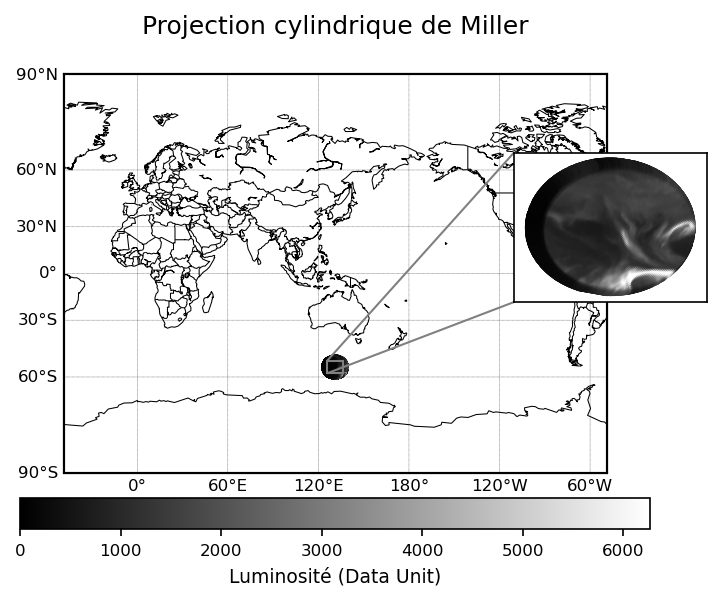

In [90]:
plotGeneralMap(file,'mill', 'Projection cylindrique de Miller', 12)

()

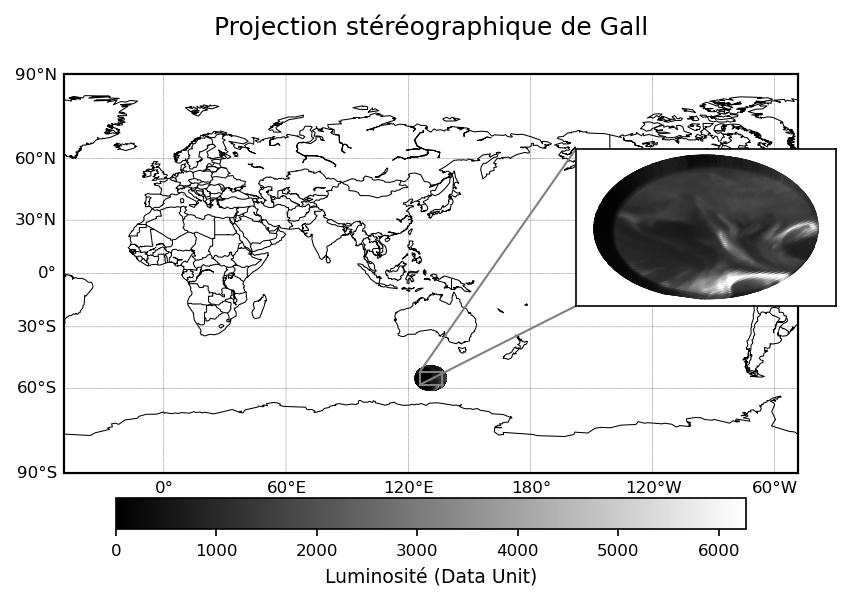

In [91]:
plotGeneralMap(file, 'gall', 'Projection stéréographique de Gall', 12)

**Cartes du globe**

()

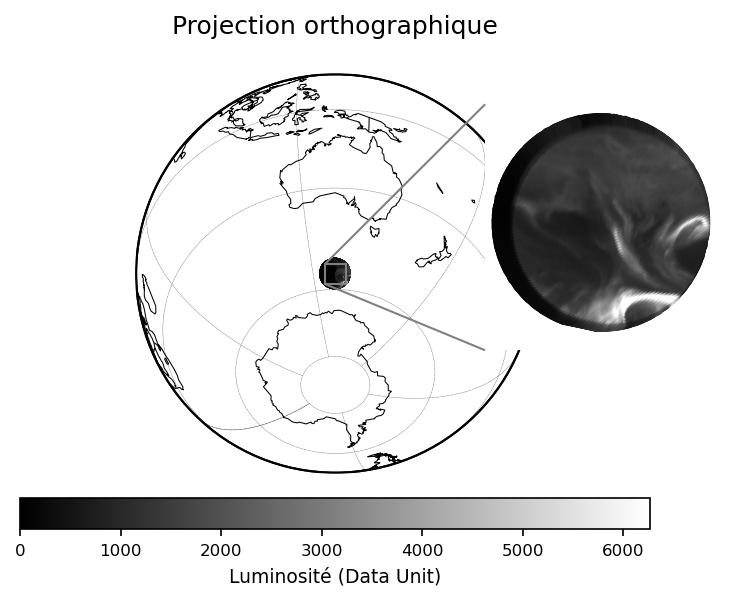

In [92]:
plotGeneralMap(file, 'ortho', 'Projection orthographique', 12)

()

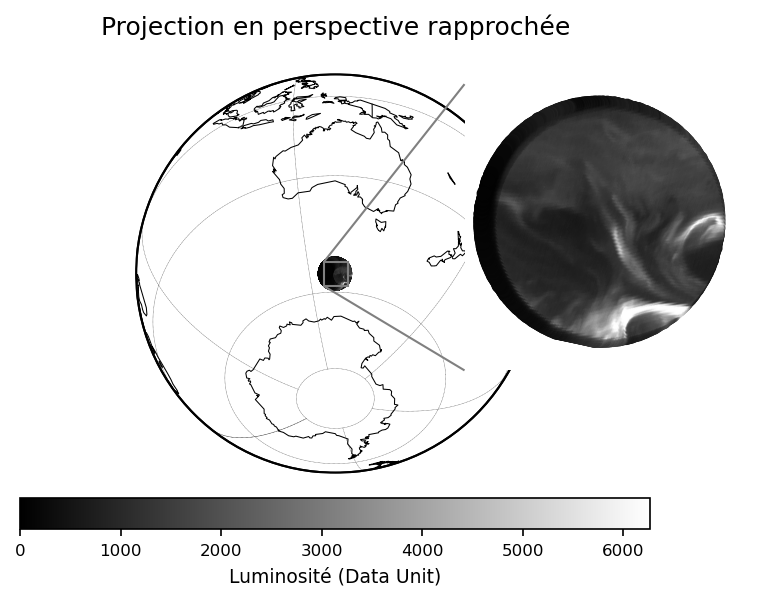

In [93]:
plotGeneralMap(file, 'nsper', 'Projection en perspective rapprochée', 12)

()

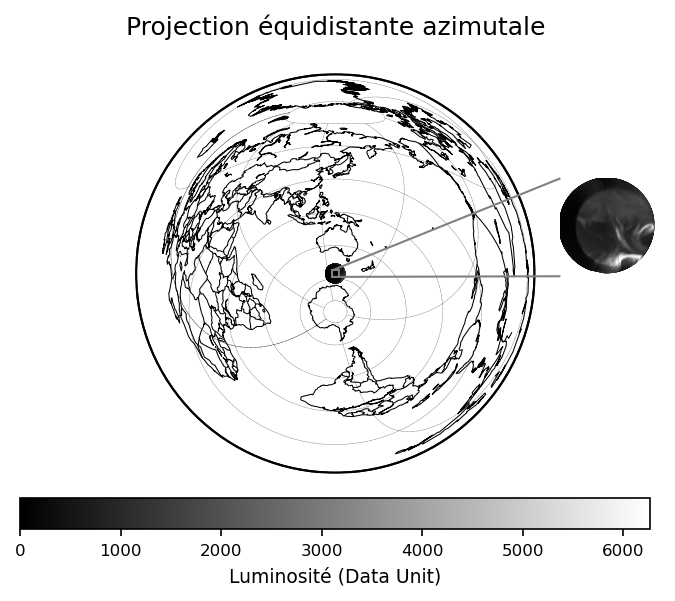

In [94]:
plotGeneralMap(file, 'aeqd', 'Projection équidistante azimutale', 15)

**Cartes rectangulaires avec transformation**

()

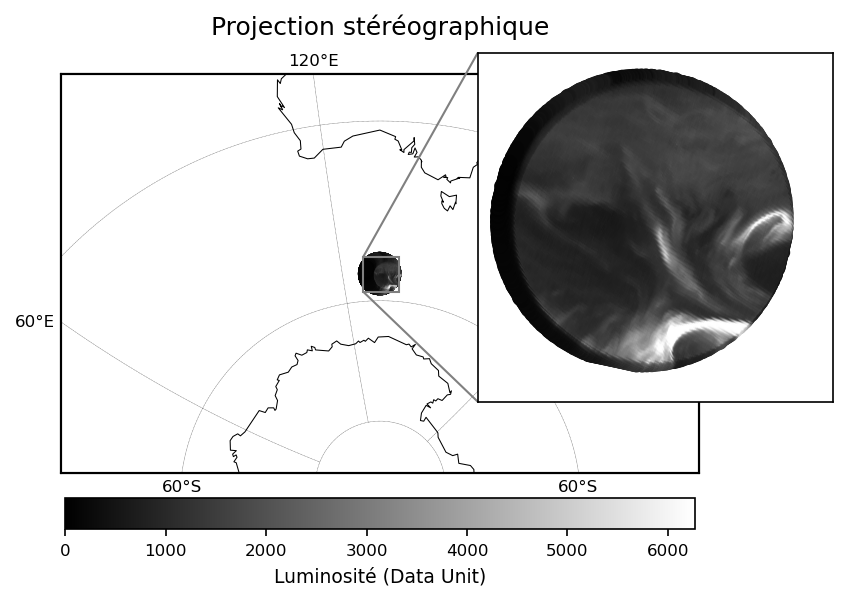

In [95]:
plotGeneralMap(file, 'stere', 'Projection stéréographique', 10)

()

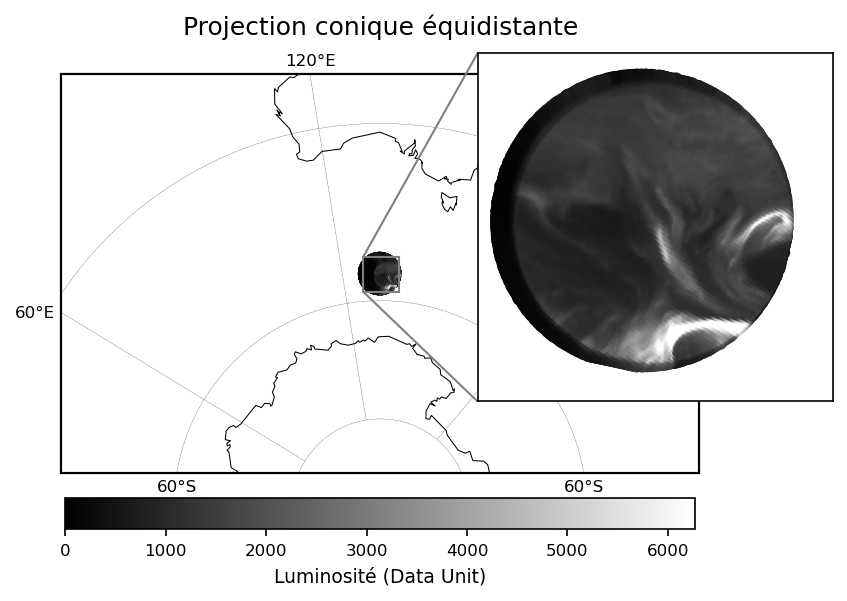

In [96]:
plotGeneralMap(file, 'eqdc', 'Projection conique équidistante', 10)

()

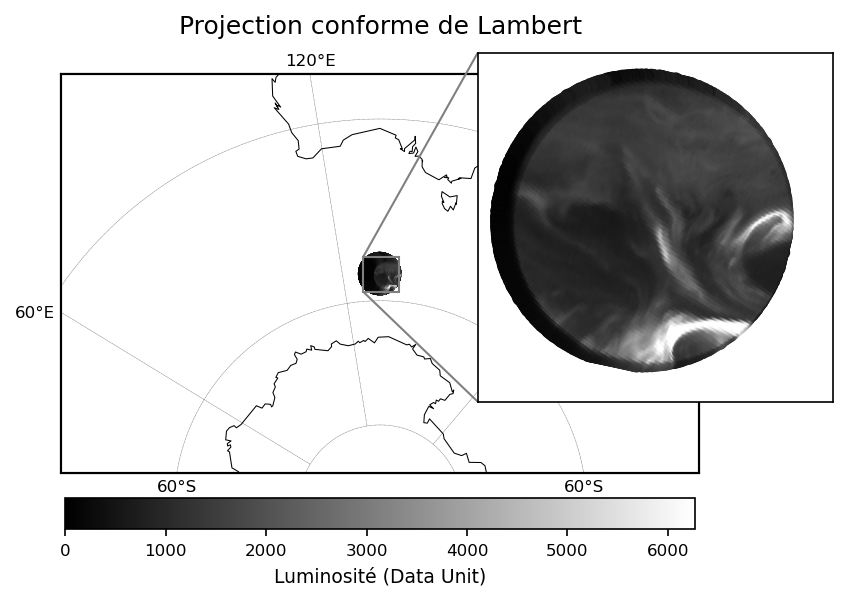

In [97]:
plotGeneralMap(file, 'lcc', 'Projection conforme de Lambert', 10)

()

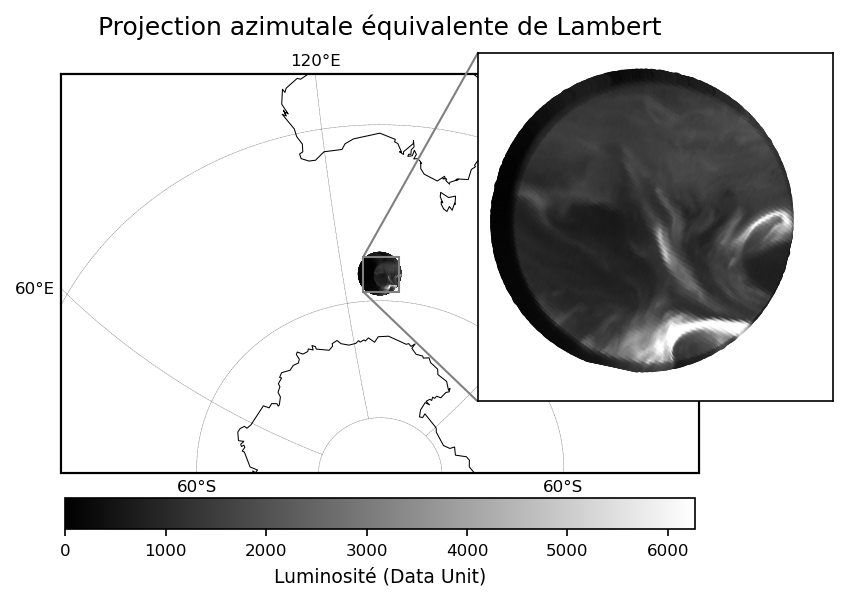

In [98]:
plotGeneralMap(file, 'laea', 'Projection azimutale équivalente de Lambert', 10)

()

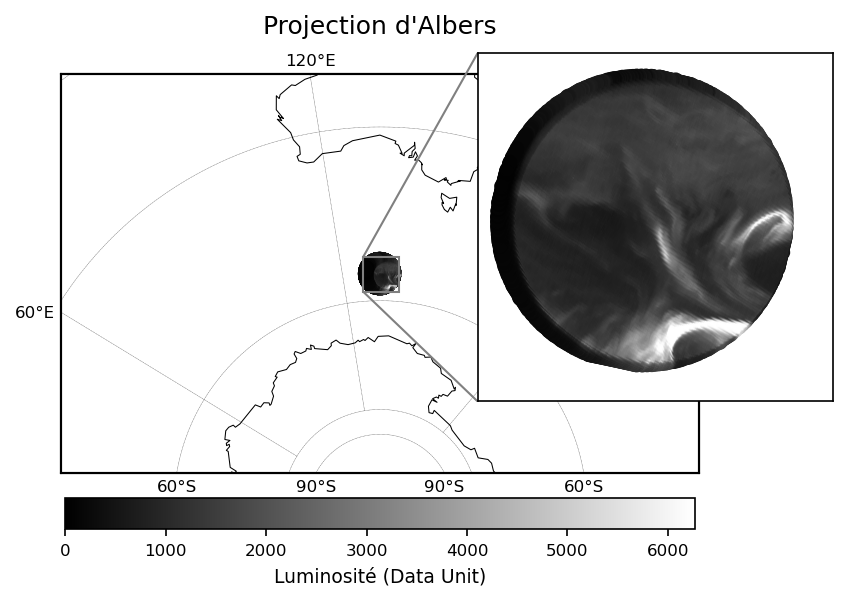

In [99]:
plotGeneralMap(file, 'aea', "Projection d'Albers", 10)

**Pôle Sud**

()

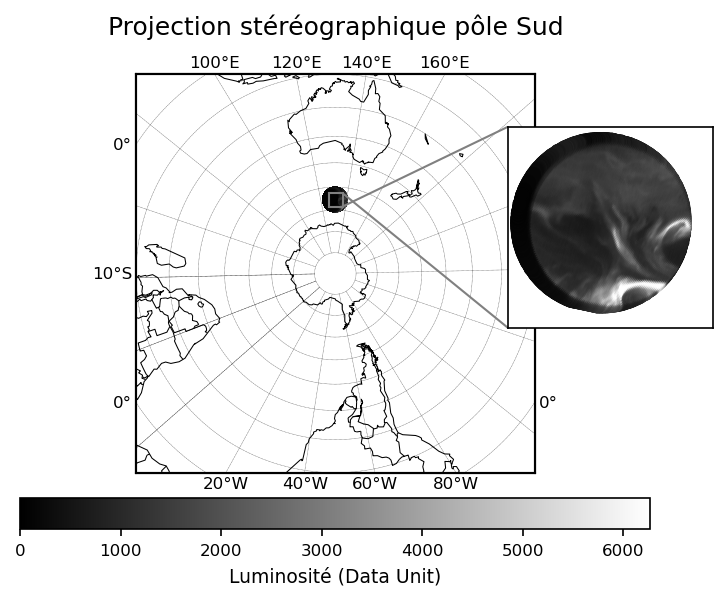

In [100]:
plotGeneralMap(file, 'spstere', 'Projection stéréographique pôle Sud', 15, interPara=10.,interMeri=20.)

()

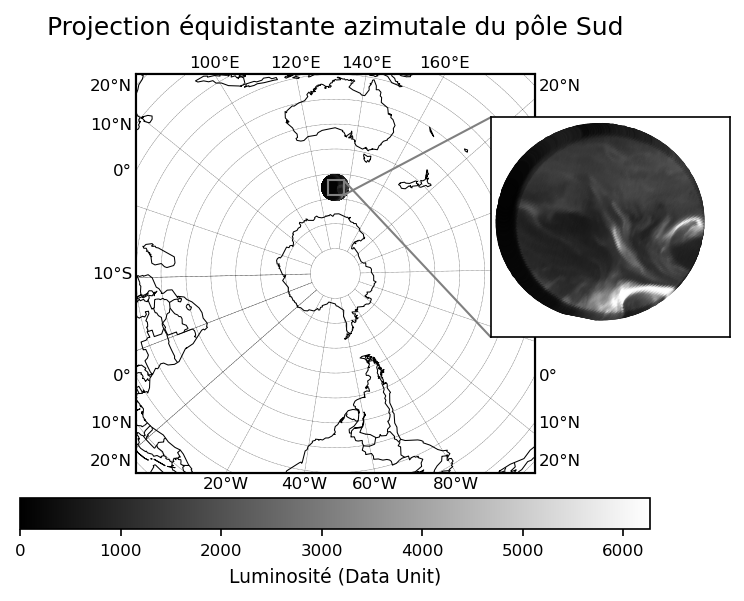

In [101]:
plotGeneralMap(file, 'spaeqd', 'Projection équidistante azimutale du pôle Sud', 15, interPara=10., interMeri=20.)

()

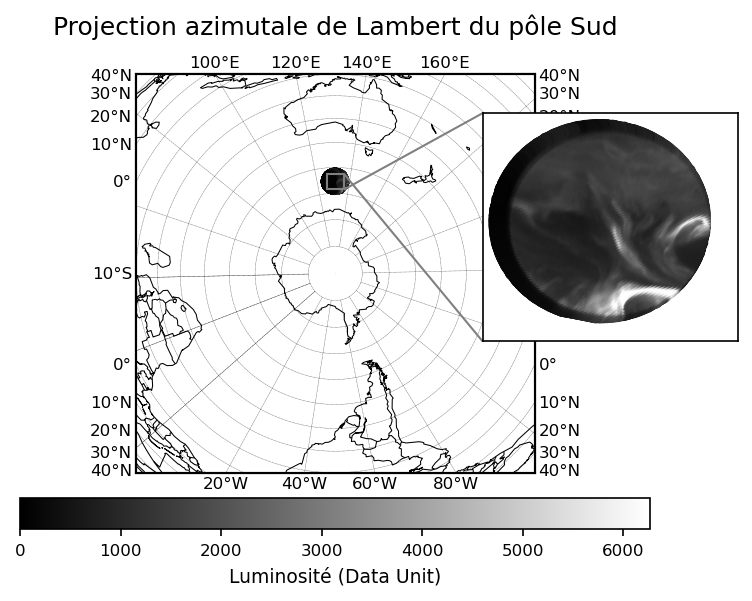

In [102]:
plotGeneralMap(file, 'splaea', 'Projection azimutale de Lambert du pôle Sud', 15, interPara=10.,interMeri=20.)

**Pôle Nord**

()

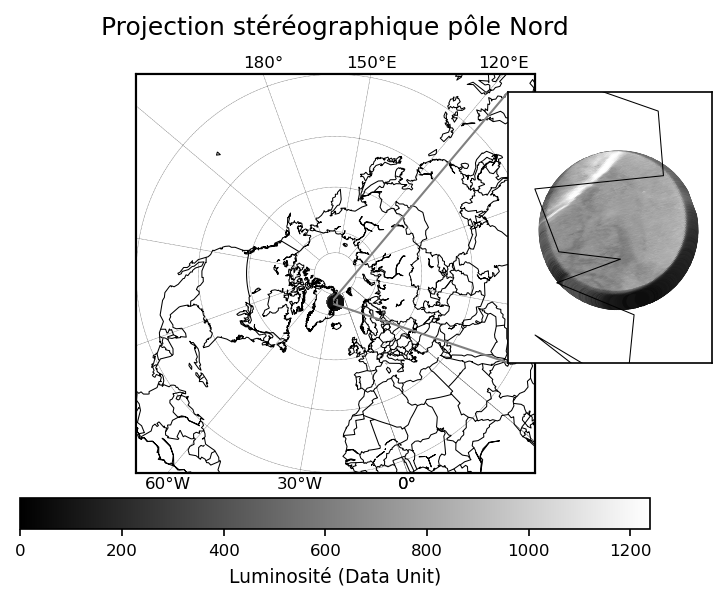

In [103]:
file='FAI_lv1_NIR_20190104_070011_070011_6.0.0.h5'
plotGeneralMap(file, 'npstere', 'Projection stéréographique pôle Nord', 60, interPara=20.,interMeri=30.)

()

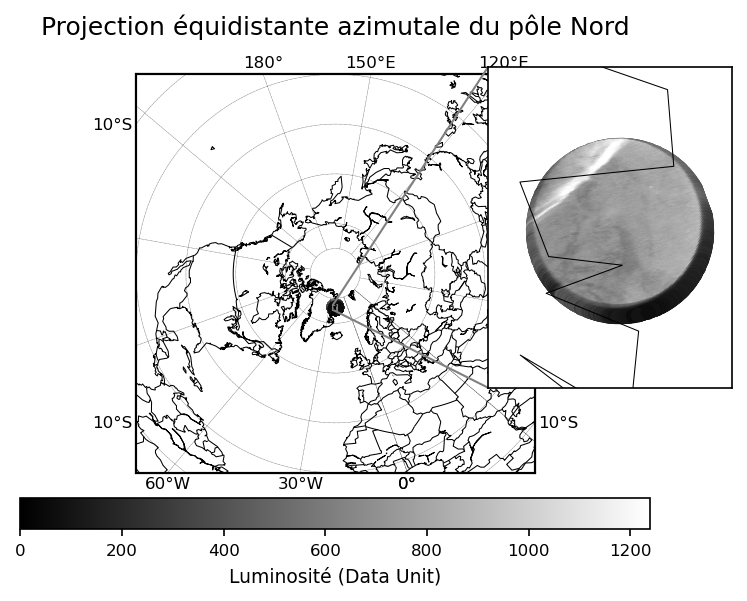

In [104]:
plotGeneralMap(file, 'npaeqd', 'Projection équidistante azimutale du pôle Nord', 60, interPara=20., interMeri=30.)

()

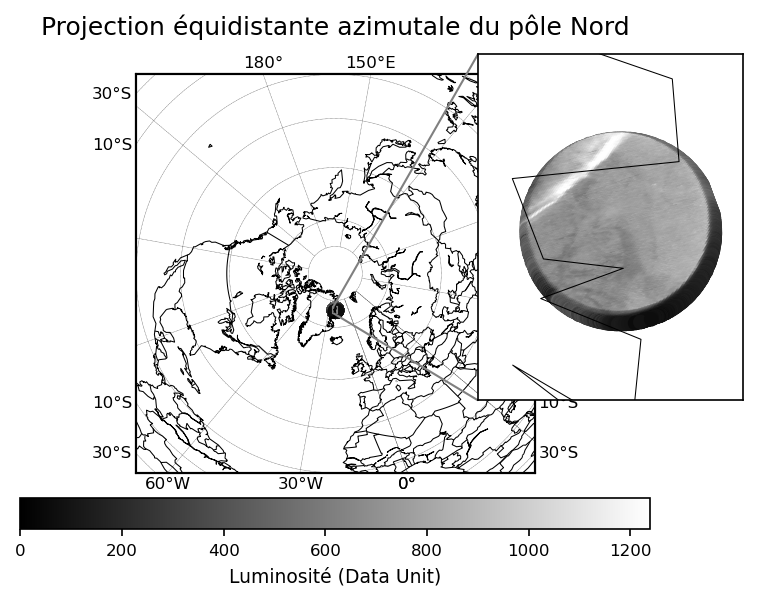

In [105]:
plotGeneralMap(file, 'nplaea', 'Projection équidistante azimutale du pôle Nord', 60, interPara=20.,interMeri=30.)

In [106]:
plt.close('all')

Here's a list of other available projections in basemap but are not supported by this script, but can be added easily.

* Gnomonic Projection (gnom)
* Geostationary Projection (geos)
* Mollweide Projection (moll)
* Hammer Projection (hammer)
* Robinson Projection (robin)
* Eckert IV Projection (eck4)
* Kavrayskiy VII Projection (kav7)
* McBryde-Thomas Flat Polar Quartic (mbtfpq)
* Sinusoidal Projection (sinu)
* Cassini Projection (cass)
* Mercator Projection (merc)
* Transverse Mercator Projection (tmerc)
* Oblique Mercator Projection (omerc)
* Polyconic Projection (poly)
* Cylindrial Equal-Area Projection (cea)
* van der Grinten Projection (vandg)